# Diffeomorphic Landmark Registration

In [1]:
# todo, sepearate learning rate for A and T
# or, use a metric

In [2]:
%matplotlib notebook

In [3]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# device for torch
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
dtype = torch.float32


## Specify parameters

In [4]:
# deformation model
# regularization strength (of the form 1/sigma^2)
sigmaR = 1e1
# smoothness length (standard deviation of a Gaussian in same units as landmarks)
sigmaL = 0.5
nt = 10 # timesteps to integrate a flow

# optimization
niter = 1000
lr = 1e-0 # learning rate for diffeomorphism
lrL = 1e-3 # learning rate for linear transform
lrT = 1e-2 # learning rate for translation

## Landmarks
Match atlas landmarks X to target landmarks Y

In [5]:
# atlas landmarks
# for this example we will chose 15 random landmarks
X = torch.rand(15,3,dtype=dtype,device=device)
Y = X + torch.randn(15,3,dtype=dtype,device=device)*0.1 + torch.randn(1,3,device=device,dtype=dtype)*0.2
N = X.shape[0]

<IPython.core.display.Javascript object>


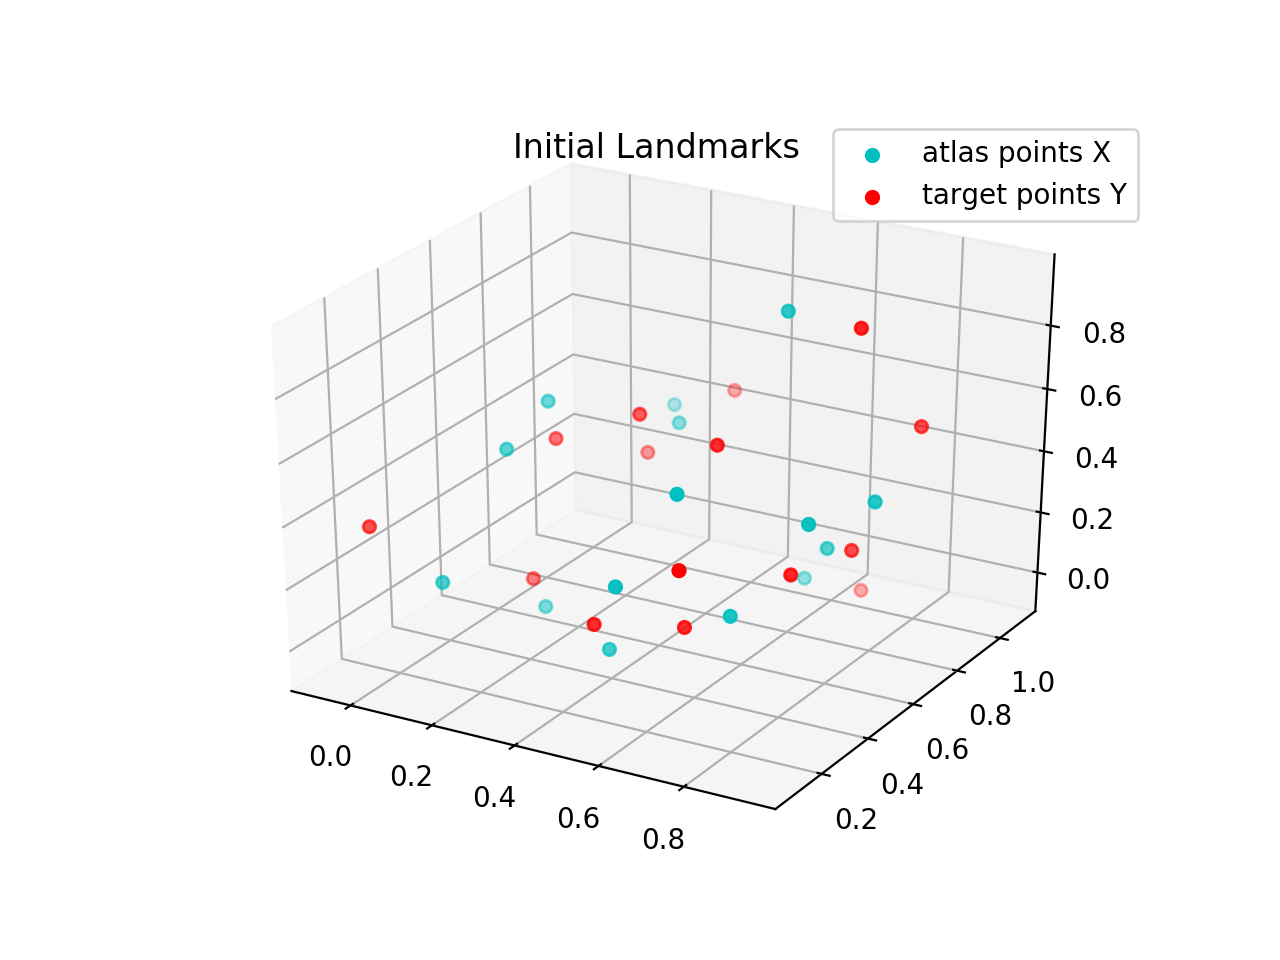

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0].detach().cpu(),X[:,1].detach().cpu(),X[:,2].detach().cpu(),c='c', label='atlas points X ')
ax.scatter(Y[:,0].detach().cpu(),Y[:,1].detach().cpu(),Y[:,2].detach().cpu(),c='r', label='target points Y')
ax.set_title('Initial Landmarks')
ax.legend()
fig.canvas.draw()

In [7]:
# initialize velocity field to optimize over and flowing points
dt = 1.0/nt
v = torch.zeros((nt,N,3),device=device,dtype=dtype,requires_grad=True)

L = torch.eye(3,device=device,dtype=dtype,requires_grad=True)
T = torch.zeros(3,device=device,dtype=dtype,requires_grad=True)

<IPython.core.display.Javascript object>


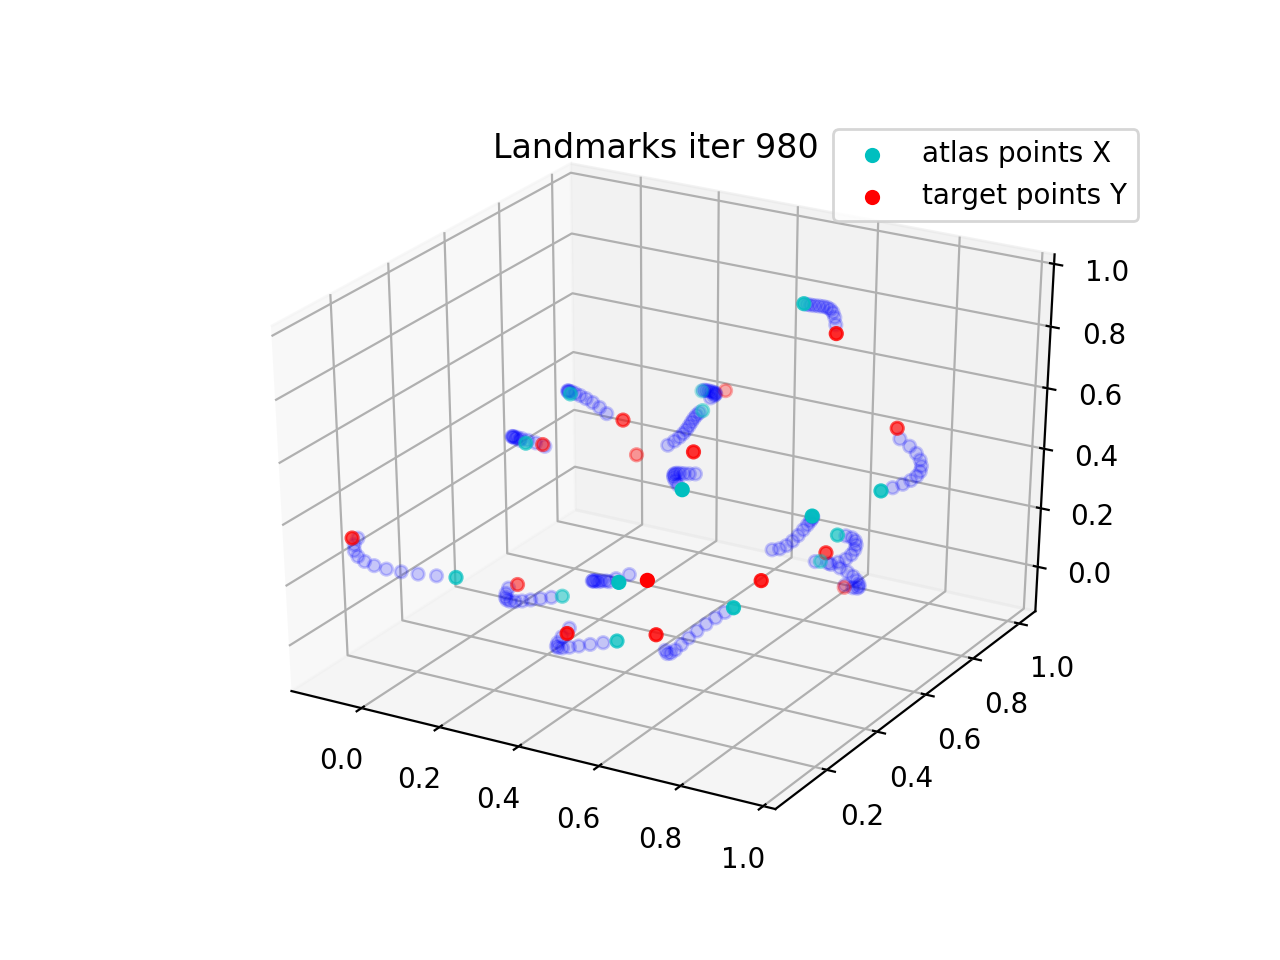

<IPython.core.display.Javascript object>


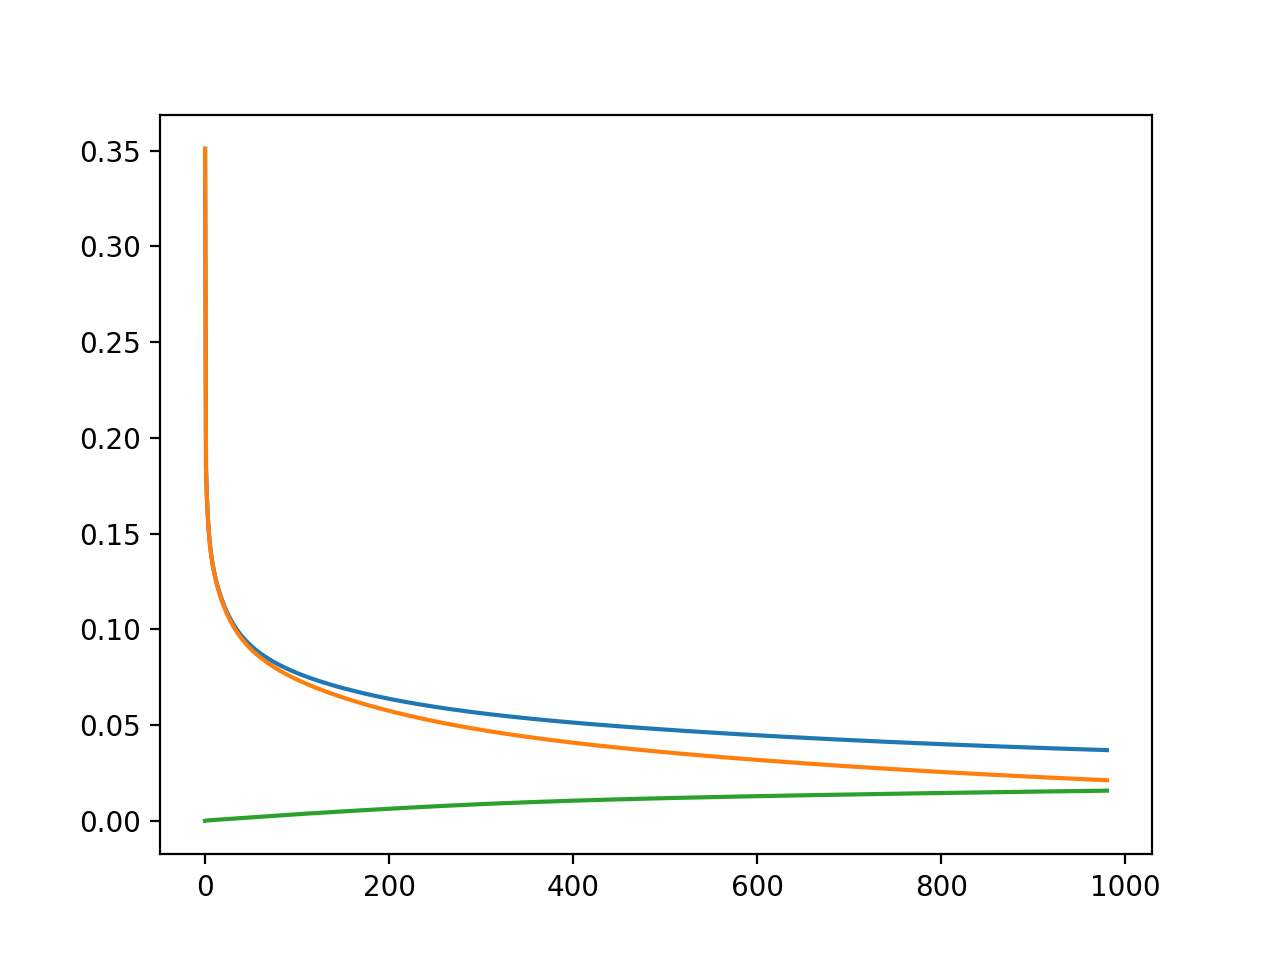

In [8]:
# perform optimization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

figE,axE = plt.subplots()
Esave = []

ndraw = 20
for it in range(niter):
    if not it%ndraw:
        ax.cla()
    
    # flow the landmarks forward
    ER = 0.0 # regularization energy
    x = torch.clone(X)
    xsave = []
    for t in range(nt):
        xsave.append(x)
        # get reg cost
        K = torch.exp( - torch.sum((x[None,:,:] - x[:,None,:])**2,-1)/2.0/sigmaL**2)
        Ki = torch.inverse(K)
        ER += torch.sum((Ki@v[t])*v[t])
        
        # update point
        x += v[t]*dt
        
        # draw it
        if not it%ndraw:
            ax.scatter(x[:,0].detach().cpu(),x[:,1].detach().cpu(),x[:,2].detach().cpu(),c='b',alpha=0.2)
    
    # multiply reg energy by normalization constant    
    ER *= dt/(2.0*sigmaR**2)
        
    # affine    
    x = x@L.T + T
    

    # matching cost
    EM = torch.sum( (x - Y)**2 )/2.0
    
    # total cost
    E = EM + ER
    
    E.backward()
    Esave.append([E.detach().cpu(), EM.detach().cpu(), ER.detach().cpu()])
    
    if not it%ndraw:
        ax.scatter(X[:,0].detach().cpu(),X[:,1].detach().cpu(),X[:,2].detach().cpu(),c='c', label='atlas points X ')
        with torch.no_grad():
            A = torch.eye(4,dtype=dtype,device=device)
            A[:3,:3] = L
            A[:3,-1] = T
            Ai = torch.inverse(A)
            AiY = Y@Ai[:3,:3].T + Ai[:3,-1]
        ax.scatter(AiY[:,0].detach().cpu(),AiY[:,1].detach().cpu(),AiY[:,2].detach().cpu(),c='r', label='target points Y')
        ax.set_title(f'Landmarks iter {it}')
        ax.legend()
        fig.canvas.draw()
    
    if not it%ndraw:
        axE.cla()
        axE.plot(Esave)
        figE.canvas.draw()
    
    with torch.no_grad():
        for t in range(nt):
            # multiply by the inverse of the metric
            K = torch.exp( - torch.sum((xsave[t][None,:,:] - xsave[t][:,None,:])**2,-1)/2.0/sigmaL**2)
            v.data[t] -= lr * (K@v.grad.data[t])                            
        L.data -= lrL * L.grad.data
        T.data -= lrT * T.grad.data
    
    # zero the gradients
    v.grad.data.zero_()
    L.grad.data.zero_()
    T.grad.data.zero_()

    